# Feature Linking

The pyOpenMS feature grouping algorithms group corresponding features
(e.g., of same analyte) from multiple
[FeatureMap](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureMap.html)
objects into a
[ConsensusMap](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.ConsensusMap.html).
Linking is primarily done based on spatial proximity (e.g., similar
retention time and m/z). It is, thus, advisable to perform a map
alignment before features linking.

Optionally, identification data can be considered to prevent linking of
features with different identifications.

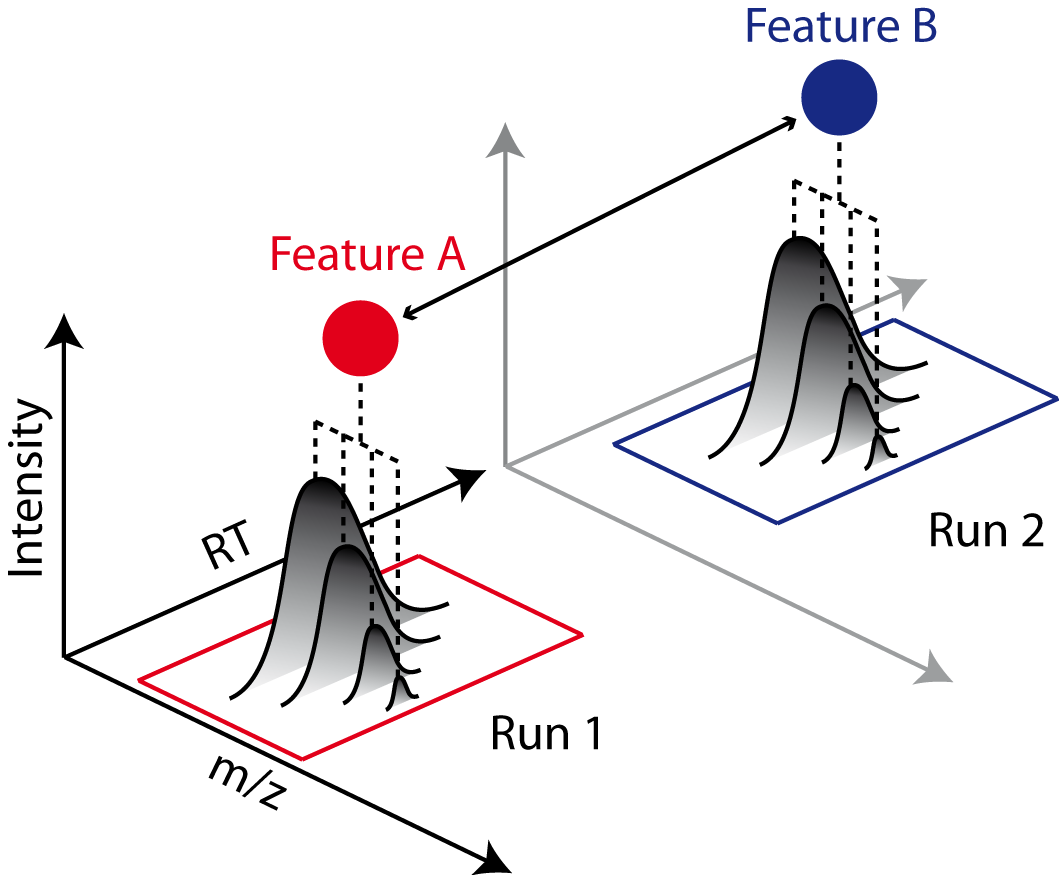

Different feature grouping algorithms with slightly different
implementations are runtime characteristics are available in pyOpenMS:

-   [FeatureGroupingAlgorithmQT](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureGroupingAlgorithmQT.html)
-   [FeatureGroupingAlgorithmKD](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureGroupingAlgorithmKD.html)
-   [FeatureGroupingAlgorithmLabeled](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureGroupingAlgorithmLabeled.html)
-   [FeatureGroupingAlgorithmUnlabeled](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureGroupingAlgorithmUnlabeled.html)

We now perform feature linking using the
[FeatureGroupingAlgorithmQT](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureGroupingAlgorithmQT.html)
algorithm.

## Download Example Data

In [ ]:
import pyopenms as oms
from urllib.request import urlretrieve

base_url = (
    "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master/src/data/"
)

feature_files = [
    "BSA1_F1.featureXML",
    "BSA2_F1.featureXML",
    "BSA3_F1.featureXML",
]

feature_maps = []

# download the feature files and store feature maps in list (feature_maps)
for feature_file in feature_files:
    urlretrieve(base_url + feature_file, feature_file)
    feature_map = oms.FeatureMap()
    oms.FeatureXMLFile().load(feature_file, feature_map)
    feature_maps.append(feature_map)

## Feature Linking Algorithm

Feature linking is the process which connects (links) features with
similar RT and m/z across different runs. This enables comparisons of
peptide signals across runs and is a prerequisite for downstream
statistical analysis. Thus, all features across all
[FeatureMap](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureMap.html)
objects will be combined into a
[ConsensusMap](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.ConsensusMap.html).
Here we use
[FeatureGroupingAlgorithmQT](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.FeatureGroupingAlgorithmQT.html)
to find corresponding features with similar RT and m/z across feature
maps. If everything goes well, we will have a lot of triplets in our
test run (we have three input maps; one feature from each feature map)
within each consensus feature. Realistically, some features will remain
unmatched, forming singletons or doublets (consensus features of size 1
or 2). These undersized consensus features can arise due to several
factors. In some cases, the signal may be genuinely absent in the
dataset, preventing feature detection. Alternatively, the
feature-finding algorithm might fail to identify the feature in all
available maps, leading to incomplete linkage. Additionally, suboptimal
parameters for feature linking, such as excessive retention time (RT)
variations across samples, can contribute to mismatches, further
reducing the likelihood of forming larger consensus features. The latter
can be corrected for using a process called map alignment, which we
addressed in a [previous chapter](map_alignment.ipynb).

In [ ]:
consensus_map = oms.ConsensusMap()

# populate the actual cmap using FeatureGroupingAlgorithmQT
feature_grouper = oms.FeatureGroupingAlgorithmQT()
# execute feature linking:
feature_grouper.group(feature_maps, consensus_map)

That's it! Now, we can print some summary information:

In [ ]:
# print some info on the consensus map
print(f"Total number of consensus features: {consensus_map.size()}\n\n")

from collections import defaultdict

def compute_feature_size_stats(consensus_map):
    size_counts = defaultdict(int)  # Default value for missing keys is 0

    for cfeature in consensus_map:
        size = len(cfeature.getFeatureList())
        size_counts[size] += 1  # No need to check if the key exists

    return size_counts

stats = compute_feature_size_stats(consensus_map)
## how many consensus features are there which contain features from 1, 2, or all 3 feature maps?
print("ConsensusFeature Size Distribution:", dict(stats), "\n\n")

for (i, cfeature) in enumerate(consensus_map):
    if i > 3:
        break
    print(
        f"ConsensusFeature: average int: {cfeature.getIntensity()}, RT: {cfeature.getRT()}, m/z: {cfeature.getMZ()}"
    )
    # The two features in map 1 and map 2 represent the same analyte at
    # slightly different RT and m/z
    for fh in cfeature.getFeatureList():
        print(f" -- Feature: map#: {fh.getMapIndex()}, int: {fh.getIntensity()}, RT: {fh.getRT()}")

This then prints:

``` output
Map 0: Filename = BSA1_F1.featureXML, Size = 256, UniqueID = 15391035140702131759
Map 1: Filename = BSA2_F1.featureXML, Size = 235, UniqueID = 4409371154349730995
Map 2: Filename = BSA3_F1.featureXML, Size = 204, UniqueID = 16851873442542870272
Total number of consensus features: 474


ConsensusFeature Size Distribution: {3: 55, 2: 111, 1: 308} 


ConsensusFeature: average int: 674365.6875, RT: 1925.75138611056, m/z: 387.7128198087733
 -- Feature: map#: 0, int: 1432460.0, RT: 1961.42395727216
 -- Feature: map#: 1, int: 285228.0, RT: 1914.26950841529
 -- Feature: map#: 2, int: 305409.0, RT: 1901.56069264423
ConsensusFeature: average int: 1154167.0, RT: 1787.5601793634498, m/z: 662.2911690419279
 -- Feature: map#: 0, int: 834075.0, RT: 1836.92005770327
 -- Feature: map#: 1, int: 2119760.0, RT: 1748.02632036743
 -- Feature: map#: 2, int: 508666.0, RT: 1777.73416001965
ConsensusFeature: average int: 562620.0, RT: 1650.6520418306134, m/z: 779.7355985805051
 -- Feature: map#: 0, int: 661665.0, RT: 1662.1136104186
 -- Feature: map#: 1, int: 751397.0, RT: 1616.78250841374
 -- Feature: map#: 2, int: 274798.0, RT: 1673.0600066595
ConsensusFeature: average int: 23445466.0, RT: 1877.1572820450535, m/z: 738.310987605286
 -- Feature: map#: 0, int: 34988800.0, RT: 1901.57762589719
 -- Feature: map#: 1, int: 25276700.0, RT: 1849.00759248543
 -- Feature: map#: 2, int: 10070900.0, RT: 1880.88662775254
```

The results here are not ideal, since we only found 55 features which
are present in all three feature maps. The remaining consensus features
have a missing value for at least one feature map. We could tweak the
parameters used for grouping, but you should make sure that the, for
example, acceptable RT deltas are sensible. There is a tradeoff between
sensitivity and specificity here.

Finally, we add some meta-data to the consensus map, which allows us to
track the input data later on if we were to store the consensus map to
disk.

In [ ]:
file_descriptions = consensus_map.getColumnHeaders()

# collect information about input maps ...
for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, oms.ColumnHeader())
    file_description.filename = feature_files[i]  ## filename
    file_description.size = feature_map.size()
    file_description.unique_id = feature_map.getUniqueId()
    file_descriptions[i] = file_description
# ... and store them in the column headers of the cmap
consensus_map.setColumnHeaders(file_descriptions)

# print the information on underlying feature maps which we just collected
file_descriptions = consensus_map.getColumnHeaders()
for index, header in file_descriptions.items():
    print(f"Map {index}: Filename = {header.filename}, Size = {header.size}, UniqueID = {header.unique_id}")